<a href="https://colab.research.google.com/github/KamonohashiPerry/kaggle/blob/master/DataScienceBowl_2019_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename =  "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


LightGBMのインストール

In [0]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

In [0]:
!pip install kaggle

In [0]:
!kaggle competitions list

ref                                            deadline             category             reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started   Knowledge       2299           False  
titanic                                        2030-01-01 00:00:00  Getting Started   Knowledge      15466            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started   Knowledge       5062            True  
connectx                                       2030-01-01 00:00:00  Getting Started   Knowledge        338           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research          Knowledge         62           False  
competitive-data-science-predict-future-sales  2020-12-31 23:59:00  Playground            Kudos       5547            True  


In [0]:
!kaggle competitions download -c data-science-bowl-2019

  0% 0.00/10.8k [00:00<?, ?B/s]
100% 10.8k/10.8k [00:00<00:00, 9.73MB/s]
 99% 393M/397M [00:15<00:00, 23.0MB/s]
100% 397M/397M [00:15<00:00, 26.3MB/s]
  0% 0.00/262k [00:00<?, ?B/s]
100% 262k/262k [00:00<00:00, 83.3MB/s]
  0% 0.00/399k [00:00<?, ?B/s]
100% 399k/399k [00:00<00:00, 123MB/s]
 81% 33.0M/40.8M [00:02<00:00, 13.0MB/s]
100% 40.8M/40.8M [00:02<00:00, 19.7MB/s]


In [0]:
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import cohen_kappa_score
import lightgbm as lgb

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from IPython.display import HTML
import warnings

pd.set_option('max_columns', 100)
pd.set_option('max_colwidth', 200)
pd.set_option('max_rows', 200)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
my_pal = sns.color_palette(n_colors=10)

In [0]:
specs = pd.read_csv('specs.csv')
ss = pd.read_csv('sample_submission.csv')

In [0]:
# ほとんど同じ内容のeventのinfoがあったので一つに統合する。
specs["info_fixed"] = specs["info"].str.replace('"', '')
specs["info_fixed"] = specs["info_fixed"].str.replace(' ', '')

specs_unique = specs[~specs['info_fixed'].duplicated(keep="first")].reset_index(drop=True)
specs_id_list = pd.merge(specs, specs_unique, on="info_fixed",how="left")

specs_id_list = specs_id_list[["event_id_x", "event_id_y"]]
specs_id_list.columns = ["event_id", "event_id_unique"]

title_list = ["12 Monkeys","Air Show","All Star Sorting","Balancing Act","Bird Measurer (Assessment)","Bottle Filler (Activity)","Bubble Bath","Bug Measurer (Activity)","Cart Balancer (Assessment)","Cauldron Filler (Assessment)","Chest Sorter (Assessment)","Chicken Balancer (Activity)","Chow Time","Costume Box","Crystal Caves - Level 1","Crystal Caves - Level 2","Crystal Caves - Level 3","Crystals Rule","Dino Dive","Dino Drink","Egg Dropper (Activity)","Fireworks (Activity)","Flower Waterer (Activity)","Happy Camel","Heavy, Heavier, Heaviest","Honey Cake","Leaf Leader","Lifting Heavy Things","Magma Peak - Level 1","Magma Peak - Level 2","Mushroom Sorter (Assessment)","Ordering Spheres","Pan Balance","Pirate's Tale","Rulers","Sandcastle Builder (Activity)","Scrub-A-Dub","Slop Problem","Treasure Map","Tree Top City - Level 1","Tree Top City - Level 2","Tree Top City - Level 3","Watering Hole (Activity)","Welcome to Lost Lagoon!"]
event_list = ['022b4259','02a42007','070a5291','08fd73f3','0d18d96c','0db6d71d','119b5b02','1325467d','1340b8d7','14de4c5d','155f62a4','15ba1109','17113b36','17ca3959','1996c610','1af8be29','1cc7cfca','1cf54632','1f19558b','25fa8af4','262136f4','27253bdc','28520915','28a4eb9a','28ed704e','28f975ea','2a444e03','2b9272f4','2c4e6db0','2dc29e21','2fb91ec1','30614231','3323d7e9','33505eae','363c86c9','363d3849','37c53127','37db1c2f','37ee8496','38074c54','392e14df','3babcb9b','3bb91dda','3d0b9317','3d63345e','3d8c61b0','3ddc79c3','3dfd4aa4','3edf6747','461eace6','46cd75b4','47026d5f','499edb7c','4a4c3d21','4b5efe37','4c2ec19f','4e5fc6f5','4ef8cdd3','51102b85','532a2afb','5348fd84','53c6e11a','562cec5f','56817e2b','56bcd38d','598f4598','5c2f29ca','5c3d2b2f','5d042115','5e109ec3','5e812b27','5f0eb72c','6088b756','63f13dd7','65a38bf7','6bf9e3e1','6c930e6e','709b1251','71e712d8','736f9581','74e5f8a7','795e4a37','7961e599','7cf1bc53','7d093bf9','7d5c30a2','7f0836bf','804ee27f','83c6c409','84538528','857f21c0','85de926c','86ba578b','86c924c4','8af75982','8fee50e2','90efca10','91561152','92687c59','93b353f2','93edfe2e','99abe2bb','9ce586dd','9d4e7b25','9e4c8c7b','9ee1c98c','a1192f43','a2df0760','a5e9da97','a6d66e51','a76029ee','a7640a16','a8cc6fec','a8efe47b','ad148f58','b012cd7f','b120f2ac','b1d5101d','b74258a0','b7530680','b7dc8128','bb3e370b','bc8f2793','bcceccc6','c0415e5c','c189aaf2','c1cac9a2','c277e121','c54cf6c5','c58186bf','c6971acf','c7128948','ca11f653','cdd22e43','cfbd47c8','d02b7a8e','d06f75b5','d122731b','d185d3ea','d2659ab4','d2e9262e','d38c2fd7','d3f1e122','d45ed6a1','d88e8f25','daac11b0','db02c830','dcaede90','dcb55a27','de26c3a6','df4fe8b6','e080a381','e694a35b','e7561dd2','e9c52111','ec138c1c','ecc36b7f','ecc6157f','f50fc6c1','fbaf3456','fcfdffb6']

In [0]:
train_labels = pd.read_csv('train_labels.csv.zip')

In [0]:
train = pd.read_csv('train.csv.zip')

for column in train.columns:
    if train[column].dtype == 'float64':
        train[column] = train[column].astype(np.float32)
    if train[column].dtype == 'int64':
        train[column] = train[column].astype(np.int32)
        
train = train.merge(specs_id_list, on="event_id", how="left")

train_df = train.sort_values( by=["installation_id", "timestamp"],ascending=True).reset_index(drop=True)
train_df["date"] = pd.to_datetime(train_df.timestamp)
train_df["date"] = train_df["date"].dt.date

## Gameに関して集計
### game_timeに関して集計するバージョンも試す

In [0]:
date_df = pd.DataFrame(pd.date_range(train_df["date"].min(), periods=(train_df["date"].max() - train_df["date"].min()).days + 1, freq='D').date, columns=['date'])

installation_id_df = pd.DataFrame(train_df['installation_id'].unique(), columns=['installation_id'])
title_df = pd.DataFrame(train_df['title'].unique(), columns=['title'])
type_df = pd.DataFrame(train_df['type'].unique(), columns=['type'])

date_df['key'] = 0
installation_id_df['key'] = 0
title_df['key'] = 0
type_df['key'] = 0

tmp_df = date_df.merge(installation_id_df, on='key')

date_installation_df = train_df.groupby(['date', 'installation_id'])['event_id'].count().reset_index()
date_installation_df['date_installation'] = date_installation_df[['date', 'installation_id']].apply(lambda x: '{}_{}'.format(x[0], x[1]), axis=1)

tmp_df['date_installation'] = tmp_df[['date', 'installation_id']].apply(lambda x: '{}_{}'.format(x[0], x[1]), axis=1)

tmp_df = tmp_df[tmp_df.date_installation.isin(date_installation_df.date_installation.tolist())].reset_index(drop=True)

tmp_df = tmp_df.merge(title_df, on='key')
tmp_df = tmp_df.merge(type_df, on='key').drop('key', axis=1)

In [0]:
train_df["game_time_fixed"] = np.where(train_df["type"]=="Clip", 1, train_df["game_time"])

In [0]:
sum_df = pd.DataFrame(train_df.groupby(['installation_id', 'date', 'title', 'type'])['game_time_fixed'].sum()).reset_index()
sum_df = tmp_df.merge(sum_df, on=['date', 'installation_id', 'title', 'type'], how='left')

sum_df = sum_df.fillna(0)
sum_df = sum_df.rename(columns={ "game_time_fixed":"count_record"})

sum_df['installation_id_title_cumsum'] = sum_df.groupby(['installation_id', 'title', 'type']).cumsum()['count_record']


In [0]:
tmp_df.shape

(6739568, 5)

In [0]:
train_df_pivot_game = pd.pivot_table(data=sum_df[sum_df["type"] == "Game"],
                                fill_value=0, 
                                index=['installation_id', 'date', 'type'],
                                columns="title",
                                aggfunc = {  'installation_id_title_cumsum' : np.sum })

train_df_pivot_activity = pd.pivot_table(data=sum_df[sum_df["type"] == "Activity"],
                                fill_value=0, 
                                index=['installation_id', 'date', 'type'],
                                columns="title",
                                aggfunc = {  'installation_id_title_cumsum' : np.sum })

train_df_pivot_assessment = pd.pivot_table(data=sum_df[sum_df["type"] == "Assessment"],
                                fill_value=0, 
                                index=['installation_id', 'date', 'type'],
                                columns="title",
                                aggfunc = {  'installation_id_title_cumsum' : np.sum })

train_df_pivot_clip = pd.pivot_table(data=sum_df[sum_df["type"] == "Clip"],
                                fill_value=0, 
                                index=['installation_id', 'date', 'type'],
                                columns="title",
                                aggfunc = {  'installation_id_title_cumsum' : np.sum })

column_name = ["installation_id", "date", "type"]
column_name.extend([ "game_" + str(i) for i in train_df_pivot_game.columns.levels[1].tolist()])
train_df_pivot_game = train_df_pivot_game.reset_index()
train_df_pivot_game.columns = column_name

column_name = ["installation_id", "date", "type"]
column_name.extend([ "activity_" + str(i) for i in train_df_pivot_activity.columns.levels[1].tolist()])
train_df_pivot_activity = train_df_pivot_activity.reset_index()
train_df_pivot_activity.columns = column_name

column_name = ["installation_id", "date", "type"]
column_name.extend([ "clip_" + str(i) for i in train_df_pivot_clip.columns.levels[1].tolist()])
train_df_pivot_clip = train_df_pivot_clip.reset_index()
train_df_pivot_clip.columns = column_name

column_name = ["installation_id", "date", "type"]
column_name.extend([ "assessment_" + str(i) for i in train_df_pivot_assessment.columns.levels[1].tolist()])
train_df_pivot_assessment = train_df_pivot_assessment.reset_index()
train_df_pivot_assessment.columns = column_name

In [0]:
assessment_date_list = pd.DataFrame(train_df[train_df['type']=='Assessment'].groupby(['installation_id', 'date', 'game_session', 'title'])['type'].count()).reset_index()
train_df_pivot_game = assessment_date_list.merge(train_df_pivot_game, on=['installation_id', 'date'], how="left")
train_df_pivot_activity = assessment_date_list.merge(train_df_pivot_activity, on=['installation_id', 'date'], how="left")
train_df_pivot_clip = assessment_date_list.merge(train_df_pivot_clip, on=['installation_id', 'date'], how="left")
train_df_pivot_assessment = assessment_date_list.merge(train_df_pivot_assessment, on=['installation_id', 'date'], how="left")


In [0]:
sum_df = pd.DataFrame(train_df['event_id_unique'].unique(), columns=['event_id_unique'])
sum_df['key'] = 0

tmp_df = date_df.merge(installation_id_df, on='key')

tmp_df['date_installation'] = tmp_df[['date', 'installation_id']].apply(lambda x: '{}_{}'.format(x[0], x[1]), axis=1)
tmp_df = tmp_df[tmp_df.date_installation.isin(date_installation_df.date_installation.tolist())].reset_index(drop=True)

tmp_df = tmp_df.merge(sum_df, on='key')
tmp_df = tmp_df.merge(type_df, on='key').drop('key', axis=1)

In [0]:
sum_df = pd.DataFrame(train_df.groupby(['installation_id', 'date', 'event_id_unique','type'])['game_session'].count()).reset_index()

In [0]:
sum_df = tmp_df.merge(sum_df, on=['date', 'installation_id', 'event_id_unique', 'type'], how='left')

In [0]:
sum_df = sum_df.fillna(0)
sum_df = sum_df.rename(columns={ "game_session":"count_record"})
sum_df['installation_id_event_id_unique_cumsum'] = sum_df.groupby(['installation_id', 'event_id_unique', 'type']).cumsum()['count_record']


In [0]:
event_df_pivot_game = pd.pivot_table(data=sum_df[sum_df["type"] == "Game"],
                                fill_value=0, 
                                index=['installation_id', 'date'],
                                columns="event_id_unique",
                                aggfunc = {  'installation_id_event_id_unique_cumsum' : np.sum })

event_df_pivot_activity = pd.pivot_table(data=sum_df[sum_df["type"] == "Activity"],
                                fill_value=0, 
                                index=['installation_id', 'date'],
                                columns="event_id_unique",
                                aggfunc = {  'installation_id_event_id_unique_cumsum' : np.sum })

event_df_pivot_clip = pd.pivot_table(data=sum_df[sum_df["type"] == "Clip"],
                                fill_value=0, 
                                index=['installation_id', 'date'],
                                columns="event_id_unique",
                                aggfunc = {  'installation_id_event_id_unique_cumsum' : np.sum })

event_df_pivot_assessment = pd.pivot_table(data=sum_df[sum_df["type"] == "Assessment"],
                                fill_value=0, 
                                index=['installation_id', 'date'],
                                columns="event_id_unique",
                                aggfunc = {  'installation_id_event_id_unique_cumsum' : np.sum })

column_name = ["installation_id", "date"]
column_name.extend([ "game_" + str(i) for i in event_df_pivot_game.columns.levels[1].tolist()])
event_df_pivot_game = event_df_pivot_game.reset_index()
event_df_pivot_game.columns = column_name

column_name = ["installation_id", "date"]
column_name.extend([ "activity_" + str(i) for i in event_df_pivot_activity.columns.levels[1].tolist()])
event_df_pivot_activity = event_df_pivot_activity.reset_index()
event_df_pivot_activity.columns = column_name

column_name = ["installation_id", "date"]
column_name.extend([ "clip_" + str(i) for i in event_df_pivot_clip.columns.levels[1].tolist()])
event_df_pivot_clip = event_df_pivot_clip.reset_index()
event_df_pivot_clip.columns = column_name

column_name = ["installation_id", "date"]
column_name.extend([ "assessment_" + str(i) for i in event_df_pivot_assessment.columns.levels[1].tolist()])
event_df_pivot_assessment = event_df_pivot_assessment.reset_index()
event_df_pivot_assessment.columns = column_name



In [0]:
event_df_pivot_game = assessment_date_list.merge(event_df_pivot_game, on=['installation_id', 'date'], how="left")
event_df_pivot_activity = assessment_date_list.merge(event_df_pivot_activity, on=['installation_id', 'date'], how="left")
event_df_pivot_clip = assessment_date_list.merge(event_df_pivot_clip, on=['installation_id', 'date'], how="left")
event_df_pivot_assessment = assessment_date_list.merge(event_df_pivot_assessment, on=['installation_id', 'date'], how="left")

train_df_pivot_game = train_df_pivot_game.merge(event_df_pivot_game, on=['installation_id','date','game_session'], how="left")
train_df_pivot_activity = train_df_pivot_activity.merge(event_df_pivot_activity, on=['installation_id','date','game_session'], how="left")
train_df_pivot_clip = train_df_pivot_clip.merge(event_df_pivot_clip, on=['installation_id','date','game_session'], how="left")
train_df_pivot_assessment = train_df_pivot_assessment.merge(event_df_pivot_assessment, on=['installation_id','date','game_session'], how="left")

train_df_pivot_game = train_df_pivot_game.drop(columns=["type_x","title_y","type_y"], axis=1)
train_df_pivot_game = train_df_pivot_game.rename(columns={"title_x" : "title_base"})

train_df_pivot_activity = train_df_pivot_activity.drop(columns=["type_x","title_y","type_y"], axis=1)
train_df_pivot_activity = train_df_pivot_activity.rename(columns={"title_x" : "title_base"})

train_df_pivot_clip = train_df_pivot_clip.drop(columns=["type_x","title_y","type_y"], axis=1)
train_df_pivot_clip = train_df_pivot_clip.rename(columns={"title_x" : "title_base"})

train_df_pivot_assessment = train_df_pivot_assessment.drop(columns=["type_x","title_y","type_y"], axis=1)
train_df_pivot_assessment = train_df_pivot_assessment.rename(columns={"title_x" : "title_base"})

train_df_pivot_game = train_df_pivot_game.merge(train_labels.drop(columns=['installation_id'], axis=1), on="game_session", how="left")
train_df_pivot_game = train_df_pivot_game[~train_df_pivot_game.duplicated(subset=["installation_id", "title"], keep='last')].reset_index(drop=True)

train_df_pivot_activity = train_df_pivot_activity.merge(train_labels.drop(columns=['installation_id'], axis=1), on="game_session", how="left")
train_df_pivot_activity = train_df_pivot_activity[~train_df_pivot_activity.duplicated(subset=["installation_id", "title"], keep='last')].reset_index(drop=True)

train_df_pivot_clip = train_df_pivot_clip.merge(train_labels.drop(columns=['installation_id'], axis=1), on="game_session", how="left")
train_df_pivot_clip = train_df_pivot_clip[~train_df_pivot_clip.duplicated(subset=["installation_id", "title"], keep='last')].reset_index(drop=True)

train_df_pivot_assessment = train_df_pivot_assessment.merge(train_labels.drop(columns=['installation_id'], axis=1), on="game_session", how="left")
train_df_pivot_assessment = train_df_pivot_assessment[~train_df_pivot_assessment.duplicated(subset=["installation_id", "title"], keep='last')].reset_index(drop=True)

train_df_pivot_game = train_df_pivot_game[~train_df_pivot_game.accuracy_group.isna()].reset_index(drop=True)
train_df_pivot_activity = train_df_pivot_activity[~train_df_pivot_activity.accuracy_group.isna()].reset_index(drop=True)
train_df_pivot_clip = train_df_pivot_clip[~train_df_pivot_clip.accuracy_group.isna()].reset_index(drop=True)
train_df_pivot_assessment = train_df_pivot_assessment[~train_df_pivot_assessment.accuracy_group.isna()].reset_index(drop=True)




## EDA

In [0]:
train_df_pivot_game.groupby("title")["accuracy"].agg([np.mean, "count"])

,mean,count
title,,
Bird Measurer (Assessment),0.417888,1587
Cart Balancer (Assessment),0.744200,2100
Cauldron Filler (Assessment),0.734015,1985
Chest Sorter (Assessment),0.238966,1724
Mushroom Sorter (Assessment),0.724751,1990


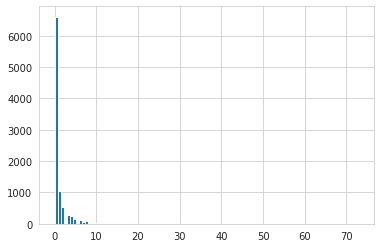

In [0]:
# accuracyが増える・減るようなeventは何なのかを見つけたい
train_df_pivot_game.groupby()

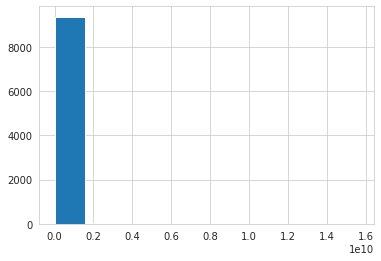

In [0]:
train_df_pivot_game["game_Scrub-A-Dub"].hist()

In [0]:
 train_df_pivot_game

,installation_id,date,game_session,title_base,game_12 Monkeys,game_Air Show,game_All Star Sorting,game_Balancing Act,game_Bird Measurer (Assessment),game_Bottle Filler (Activity),game_Bubble Bath,game_Bug Measurer (Activity),game_Cart Balancer (Assessment),game_Cauldron Filler (Assessment),game_Chest Sorter (Assessment),game_Chicken Balancer (Activity),game_Chow Time,game_Costume Box,game_Crystal Caves - Level 1,game_Crystal Caves - Level 2,game_Crystal Caves - Level 3,game_Crystals Rule,game_Dino Dive,game_Dino Drink,game_Egg Dropper (Activity),game_Fireworks (Activity),game_Flower Waterer (Activity),game_Happy Camel,"game_Heavy, Heavier, Heaviest",game_Honey Cake,game_Leaf Leader,game_Lifting Heavy Things,game_Magma Peak - Level 1,game_Magma Peak - Level 2,game_Mushroom Sorter (Assessment),game_Ordering Spheres,game_Pan Balance,game_Pirate's Tale,game_Rulers,game_Sandcastle Builder (Activity),game_Scrub-A-Dub,game_Slop Problem,game_Treasure Map,game_Tree Top City - Level 1,game_Tree Top City - Level 2,game_Tree Top City - Level 3,game_Watering Hole (Activity),game_Welcome to Lost Lagoon!,type,game_022b4259,...,game_b120f2ac,game_b1d5101d,game_b74258a0,game_b7530680,game_b7dc8128,game_bb3e370b,game_bc8f2793,game_bcceccc6,game_c0415e5c,game_c189aaf2,game_c1cac9a2,game_c277e121,game_c54cf6c5,game_c58186bf,game_c6971acf,game_c7128948,game_ca11f653,game_cdd22e43,game_cfbd47c8,game_d02b7a8e,game_d06f75b5,game_d122731b,game_d185d3ea,game_d2659ab4,game_d2e9262e,game_d38c2fd7,game_d3f1e122,game_d45ed6a1,game_d88e8f25,game_daac11b0,game_db02c830,game_dcaede90,game_dcb55a27,game_de26c3a6,game_df4fe8b6,game_e080a381,game_e694a35b,game_e7561dd2,game_e9c52111,game_ec138c1c,game_ecc36b7f,game_ecc6157f,game_f50fc6c1,game_fbaf3456,game_fcfdffb6,title,num_correct,num_incorrect,accuracy,accuracy_group
0,0006a69f,2019-08-06,9501794defd84e4d,Mushroom Sorter (Assessment),0,"(3291.0, 1362079427.0]","(1021070.0, 10624275592.0]",0,0,0,7184633,0,0,0,0,0,0,0,0,0,0,22883939,0,5448683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10678304,0,0,0,0,0,0,0,42,0,...,4,0,0,0,4,0,0,140,0,5,2,4,2,0,1,0,6,0,0,1,2,0,0,1,0,0,0,4,13,6,0,10,2,0,13,0,0,0,0,0,1,0,0,0,0,Mushroom Sorter (Assessment),1.0,1.0,0.500000,2.0
1,0006a69f,2019-08-06,a9ef3ecb3d1acc6a,Bird Measurer (Assessment),0,"(3291.0, 1362079427.0]","(1021070.0, 10624275592.0]",0,0,0,7184633,0,0,0,0,0,0,0,0,0,0,22883939,0,5448683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10678304,0,0,0,0,0,0,0,32,0,...,4,0,0,0,4,0,0,140,0,5,2,4,2,0,1,0,6,0,0,1,2,0,0,1,0,0,0,4,13,6,0,10,2,0,13,0,0,0,0,0,1,0,0,0,0,Bird Measurer (Assessment),1.0,0.0,1.000000,3.0
2,0006c192,2019-09-14,197a373a77101924,Cauldron Filler (Assessment),0,"(-0.001, 3291.0]","(-0.001, 1021070.0]",0,0,0,8226380,0,0,0,0,0,3076451,0,0,0,0,0,14287693,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22311891,0,0,0,0,0,0,0,24,0,...,0,0,0,0,0,0,0,179,11,3,1,0,1,0,0,0,0,0,13,0,1,0,4,0,0,0,0,0,10,0,0,6,0,0,10,0,0,0,0,0,1,0,0,0,0,Cauldron Filler (Assessment),1.0,0.0,1.000000,3.0
3,0006c192,2019-10-01,957406a905d59afd,Bird Measurer (Assessment),0,"(-0.001, 3291.0]","(-0.001, 1021070.0]",0,0,0,8226380,0,0,0,0,0,3076451,0,0,0,0,46230,14287693,0,0,0,0,0,0,0,0,0,0,0,0,0,73775,0,0,0,22311891,0,0,0,0,0,0,0,200,0,...,0,0,0,0,0,0,0,182,11,3,1,0,1,0,0,0,0,0,13,0,1,0,4,0,0,0,0,0,10,0,0,6,0,0,10,0,0,0,0,0,1,0,0,0,0,Bird Measurer (Assessment),1.0,1.0,0.500000,2.0
4,0006c192,2019-10-01,b2297d292892745a,Mushroom Sorter (Assessment),0,"(-0.001, 3291.0]","(-0.001, 1021070.0]",0,0,0,8226380,0,0,0,0,0,3076451,0,0,0,0,46230,14287693,0,0,0,0,0,0,0,0,0,0,0,0,0,73775,0,0,0,22311891,0,0,0,0,0,0,0,116,0,...,0,0,0,0,0,0,0,182,11,3,1,0,1,0,0,0,0,0,13,0,1,0,4,0,0,0,0,0,10,0,0,6,0,0,10,0,0,0,0,0,1,0,0,0,0,Mushroom Sorter (Assessment),0.0,4.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [0]:
import copy

train_df_pivot_game_bins = copy.deepcopy(train_df_pivot_game)
train_df_pivot_activity_bins = copy.deepcopy(train_df_pivot_activity)
train_df_pivot_clip_bins = copy.deepcopy(train_df_pivot_clip)
train_df_pivot_assessment_bins = copy.deepcopy(train_df_pivot_assessment)

column_str_list = ["game_" + str(i) for i in title_list]
column_str_list.extend(["game_" + str(i) for i in event_list])

for i in column_str_list:
  train_df_pivot_game_bins[i] = np.where(train_df_pivot_game_bins[i] > 0, 1, 0)

column_str_list = ["activity_" + str(i) for i in title_list]
column_str_list.extend(["activity_" + str(i) for i in event_list])

for i in column_str_list:
  train_df_pivot_activity_bins[i] = np.where(train_df_pivot_activity_bins[i] > 0, 1, 0)

column_str_list = ["clip_" + str(i) for i in title_list]
column_str_list.extend(["clip_" + str(i) for i in event_list])

for i in column_str_list:
  train_df_pivot_clip_bins[i] = np.where(train_df_pivot_clip_bins[i] > 0, 1, 0)

column_str_list = ["assessment_" + str(i) for i in title_list]
column_str_list.extend(["assessment_" + str(i) for i in event_list])

for i in column_str_list:
  train_df_pivot_assessment_bins[i] = np.where(train_df_pivot_assessment_bins[i] > 0, 1, 0)


In [0]:
column_str_list = ["game_" + str(i) for i in title_list]
column_str_list.extend(["game_" + str(i) for i in event_list])

train_df_pivot_game_bins.groupby("accuracy_group")[column_str_list].agg([np.mean]).round(2)

,game_12 Monkeys,game_Air Show,game_All Star Sorting,game_Balancing Act,game_Bird Measurer (Assessment),game_Bottle Filler (Activity),game_Bubble Bath,game_Bug Measurer (Activity),game_Cart Balancer (Assessment),game_Cauldron Filler (Assessment),game_Chest Sorter (Assessment),game_Chicken Balancer (Activity),game_Chow Time,game_Costume Box,game_Crystal Caves - Level 1,game_Crystal Caves - Level 2,game_Crystal Caves - Level 3,game_Crystals Rule,game_Dino Dive,game_Dino Drink,game_Egg Dropper (Activity),game_Fireworks (Activity),game_Flower Waterer (Activity),game_Happy Camel,"game_Heavy, Heavier, Heaviest",game_Honey Cake,game_Leaf Leader,game_Lifting Heavy Things,game_Magma Peak - Level 1,game_Magma Peak - Level 2,game_Mushroom Sorter (Assessment),game_Ordering Spheres,game_Pan Balance,game_Pirate's Tale,game_Rulers,game_Sandcastle Builder (Activity),game_Scrub-A-Dub,game_Slop Problem,game_Treasure Map,game_Tree Top City - Level 1,game_Tree Top City - Level 2,game_Tree Top City - Level 3,game_Watering Hole (Activity),game_Welcome to Lost Lagoon!,game_022b4259,game_02a42007,game_070a5291,game_08fd73f3,game_0d18d96c,game_0db6d71d,...,game_a7640a16,game_a8cc6fec,game_a8efe47b,game_ad148f58,game_b012cd7f,game_b120f2ac,game_b1d5101d,game_b74258a0,game_b7530680,game_b7dc8128,game_bb3e370b,game_bc8f2793,game_bcceccc6,game_c0415e5c,game_c189aaf2,game_c1cac9a2,game_c277e121,game_c54cf6c5,game_c58186bf,game_c6971acf,game_c7128948,game_ca11f653,game_cdd22e43,game_cfbd47c8,game_d02b7a8e,game_d06f75b5,game_d122731b,game_d185d3ea,game_d2659ab4,game_d2e9262e,game_d38c2fd7,game_d3f1e122,game_d45ed6a1,game_d88e8f25,game_daac11b0,game_db02c830,game_dcaede90,game_dcb55a27,game_de26c3a6,game_df4fe8b6,game_e080a381,game_e694a35b,game_e7561dd2,game_e9c52111,game_ec138c1c,game_ecc36b7f,game_ecc6157f,game_f50fc6c1,game_fbaf3456,game_fcfdffb6
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
accuracy_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0,0.45,0.53,0,0,0,0.43,0,0,0,0,0,0.62,0,0,0,0,0.43,0.45,0.49,0,0,0,0.46,0,0,0.45,0,0,0,0,0,0.51,0,0,0,0.52,0,0,0,0,0,0,0,0,0,0,0.59,0,0,...,0.84,0,0,0.20,0.70,0.38,0.48,0,0,0.54,0,0.39,0.73,0.37,0.63,0.43,0.38,0.38,0,0.63,0,0.47,0,0.59,0.43,0.36,0,0.57,0.26,0,0,0,0.38,0.62,0.47,0,0.51,0.21,0,0.61,0.23,0,0.40,0,0,0.27,0.01,0,0,0
1.0,0,0.52,0.60,0,0,0,0.48,0,0,0,0,0,0.62,0,0,0,0,0.50,0.51,0.53,0,0,0,0.51,0,0,0.49,0,0,0,0,0,0.49,0,0,0,0.56,0,0,0,0,0,0,0,0,0,0,0.68,0,0,...,0.85,0,0,0.26,0.76,0.44,0.51,0,0,0.61,0,0.41,0.78,0.46,0.70,0.46,0.44,0.45,0,0.67,0,0.56,0,0.61,0.50,0.43,0,0.58,0.29,0,0,0,0.44,0.70,0.56,0,0.55,0.28,0,0.70,0.21,0,0.44,0,0,0.31,0.01,0,0,0
2.0,0,0.50,0.56,0,0,0,0.46,0,0,0,0,0,0.63,0,0,0,0,0.47,0.48,0.51,0,0,0,0.51,0,0,0.49,0,0,0,0,0,0.46,0,0,0,0.54,0,0,0,0,0,0,0,0,0,0,0.69,0,0,...,0.84,0,0,0.27,0.75,0.39,0.49,0,0,0.56,0,0.37,0.79,0.44,0.67,0.50,0.39,0.43,0,0.66,0,0.53,0,0.62,0.45,0.41,0,0.58,0.31,0,0,0,0.39,0.70,0.53,0,0.53,0.25,0,0.70,0.16,0,0.41,0,0,0.31,0.01,0,0,0
3.0,0,0.53,0.57,0,0,0,0.47,0,0,0,0,0,0.64,0,0,0,0,0.48,0.49,0.51,0,0,0,0.53,0,0,0.51,0,0,0,0,0,0.49,0,0,0,0.55,0,0,0,0,0,0,0,0,0,0,0.70,0,0,...,0.85,0,0,0.29,0.79,0.37,0.48,0,0,0.58,0,0.39,0.77,0.44,0.68,0.50,0.37,0.44,0,0.68,0,0.54,0,0.63,0.44,0.42,0,0.59,0.32,0,0,0,0.37,0.67,0.53,0,0.54,0.28,0,0.66,0.17,0,0.44,0,0,0.30,0.00,0,0,0


+ game_08fd73f3:クラス0が少ないので簡単ということ？
+ 

In [0]:
column_str_list = ["clip_" + str(i) for i in title_list]
column_str_list.extend(["clip_" + str(i) for i in event_list])

train_df_pivot_clip_bins.groupby("accuracy_group")[column_str_list].agg([np.mean]).round(2)

,clip_12 Monkeys,clip_Air Show,clip_All Star Sorting,clip_Balancing Act,clip_Bird Measurer (Assessment),clip_Bottle Filler (Activity),clip_Bubble Bath,clip_Bug Measurer (Activity),clip_Cart Balancer (Assessment),clip_Cauldron Filler (Assessment),clip_Chest Sorter (Assessment),clip_Chicken Balancer (Activity),clip_Chow Time,clip_Costume Box,clip_Crystal Caves - Level 1,clip_Crystal Caves - Level 2,clip_Crystal Caves - Level 3,clip_Crystals Rule,clip_Dino Dive,clip_Dino Drink,clip_Egg Dropper (Activity),clip_Fireworks (Activity),clip_Flower Waterer (Activity),clip_Happy Camel,"clip_Heavy, Heavier, Heaviest",clip_Honey Cake,clip_Leaf Leader,clip_Lifting Heavy Things,clip_Magma Peak - Level 1,clip_Magma Peak - Level 2,clip_Mushroom Sorter (Assessment),clip_Ordering Spheres,clip_Pan Balance,clip_Pirate's Tale,clip_Rulers,clip_Sandcastle Builder (Activity),clip_Scrub-A-Dub,clip_Slop Problem,clip_Treasure Map,clip_Tree Top City - Level 1,clip_Tree Top City - Level 2,clip_Tree Top City - Level 3,clip_Watering Hole (Activity),clip_Welcome to Lost Lagoon!,clip_022b4259,clip_02a42007,clip_070a5291,clip_08fd73f3,clip_0d18d96c,clip_0db6d71d,...,clip_a7640a16,clip_a8cc6fec,clip_a8efe47b,clip_ad148f58,clip_b012cd7f,clip_b120f2ac,clip_b1d5101d,clip_b74258a0,clip_b7530680,clip_b7dc8128,clip_bb3e370b,clip_bc8f2793,clip_bcceccc6,clip_c0415e5c,clip_c189aaf2,clip_c1cac9a2,clip_c277e121,clip_c54cf6c5,clip_c58186bf,clip_c6971acf,clip_c7128948,clip_ca11f653,clip_cdd22e43,clip_cfbd47c8,clip_d02b7a8e,clip_d06f75b5,clip_d122731b,clip_d185d3ea,clip_d2659ab4,clip_d2e9262e,clip_d38c2fd7,clip_d3f1e122,clip_d45ed6a1,clip_d88e8f25,clip_daac11b0,clip_db02c830,clip_dcaede90,clip_dcb55a27,clip_de26c3a6,clip_df4fe8b6,clip_e080a381,clip_e694a35b,clip_e7561dd2,clip_e9c52111,clip_ec138c1c,clip_ecc36b7f,clip_ecc6157f,clip_f50fc6c1,clip_fbaf3456,clip_fcfdffb6
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
accuracy_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.39,0,0,0.43,0,0,0,0,0,0,0,0,0,0.37,0.77,0.82,0.80,0,0,0,0,0,0,0,0.38,0.39,0,0.44,0.73,0.77,0,0.50,0,0.42,0.35,0,0,0.45,0.31,0.74,0.76,0.69,0,0.75,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1.0,0.44,0,0,0.45,0,0,0,0,0,0,0,0,0,0.43,0.73,0.77,0.75,0,0,0,0,0,0,0,0.40,0.39,0,0.43,0.71,0.78,0,0.55,0,0.46,0.40,0,0,0.48,0.37,0.75,0.79,0.75,0,0.73,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2.0,0.42,0,0,0.45,0,0,0,0,0,0,0,0,0,0.40,0.72,0.75,0.72,0,0,0,0,0,0,0,0.35,0.40,0,0.41,0.69,0.77,0,0.51,0,0.43,0.37,0,0,0.45,0.35,0.71,0.75,0.69,0,0.73,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3.0,0.42,0,0,0.46,0,0,0,0,0,0,0,0,0,0.39,0.71,0.77,0.74,0,0,0,0,0,0,0,0.36,0.40,0,0.42,0.69,0.75,0,0.51,0,0.42,0.33,0,0,0.44,0.35,0.72,0.76,0.70,0,0.73,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


+ 

In [0]:
column_str_list = ["activity_" + str(i) for i in title_list]
column_str_list.extend(["activity_" + str(i) for i in event_list])

train_df_pivot_activity_bins.groupby("accuracy_group")[column_str_list].agg([np.mean]).round(2)

,activity_12 Monkeys,activity_Air Show,activity_All Star Sorting,activity_Balancing Act,activity_Bird Measurer (Assessment),activity_Bottle Filler (Activity),activity_Bubble Bath,activity_Bug Measurer (Activity),activity_Cart Balancer (Assessment),activity_Cauldron Filler (Assessment),activity_Chest Sorter (Assessment),activity_Chicken Balancer (Activity),activity_Chow Time,activity_Costume Box,activity_Crystal Caves - Level 1,activity_Crystal Caves - Level 2,activity_Crystal Caves - Level 3,activity_Crystals Rule,activity_Dino Dive,activity_Dino Drink,activity_Egg Dropper (Activity),activity_Fireworks (Activity),activity_Flower Waterer (Activity),activity_Happy Camel,"activity_Heavy, Heavier, Heaviest",activity_Honey Cake,activity_Leaf Leader,activity_Lifting Heavy Things,activity_Magma Peak - Level 1,activity_Magma Peak - Level 2,activity_Mushroom Sorter (Assessment),activity_Ordering Spheres,activity_Pan Balance,activity_Pirate's Tale,activity_Rulers,activity_Sandcastle Builder (Activity),activity_Scrub-A-Dub,activity_Slop Problem,activity_Treasure Map,activity_Tree Top City - Level 1,activity_Tree Top City - Level 2,activity_Tree Top City - Level 3,activity_Watering Hole (Activity),activity_Welcome to Lost Lagoon!,activity_022b4259,activity_02a42007,activity_070a5291,activity_08fd73f3,activity_0d18d96c,activity_0db6d71d,...,activity_a7640a16,activity_a8cc6fec,activity_a8efe47b,activity_ad148f58,activity_b012cd7f,activity_b120f2ac,activity_b1d5101d,activity_b74258a0,activity_b7530680,activity_b7dc8128,activity_bb3e370b,activity_bc8f2793,activity_bcceccc6,activity_c0415e5c,activity_c189aaf2,activity_c1cac9a2,activity_c277e121,activity_c54cf6c5,activity_c58186bf,activity_c6971acf,activity_c7128948,activity_ca11f653,activity_cdd22e43,activity_cfbd47c8,activity_d02b7a8e,activity_d06f75b5,activity_d122731b,activity_d185d3ea,activity_d2659ab4,activity_d2e9262e,activity_d38c2fd7,activity_d3f1e122,activity_d45ed6a1,activity_d88e8f25,activity_daac11b0,activity_db02c830,activity_dcaede90,activity_dcb55a27,activity_de26c3a6,activity_df4fe8b6,activity_e080a381,activity_e694a35b,activity_e7561dd2,activity_e9c52111,activity_ec138c1c,activity_ecc36b7f,activity_ecc6157f,activity_f50fc6c1,activity_fbaf3456,activity_fcfdffb6
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
accuracy_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0,0.56,0,0.48,0,0,0,0.47,0,0,0,0,0,0,0,0,0.53,0.60,0.48,0,0,0,0,0,0,0,0,0,0,0,0,0.70,0,0,0,0,0,0,0.51,0,0.42,0.60,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0.56,0,0.55,0,0,0,0,0,0,0,0.58,0,0,0,0.43,0,0,0,0,0,0,0.43,0,0.54,0,0,0,0,0,0,0.46,0,0,0.60,0,0.54,0,0,0.03,0.44,0,0.40
1.0,0,0,0,0,0,0.62,0,0.56,0,0,0,0.46,0,0,0,0,0,0,0,0,0.53,0.66,0.56,0,0,0,0,0,0,0,0,0,0,0,0,0.71,0,0,0,0,0,0,0.57,0,0.53,0.66,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0.62,0,0.61,0,0,0,0,0,0,0,0.59,0,0,0,0.43,0,0,0,0,0,0,0.54,0,0.60,0,0,0,0,0,0,0.56,0,0,0.66,0,0.61,0,0,0.03,0.52,0,0.50
2.0,0,0,0,0,0,0.60,0,0.50,0,0,0,0.49,0,0,0,0,0,0,0,0,0.50,0.63,0.52,0,0,0,0,0,0,0,0,0,0,0,0,0.67,0,0,0,0,0,0,0.55,0,0.47,0.63,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0.60,0,0.60,0,0,0,0,0,0,0,0.55,0,0,0,0.47,0,0,0,0,0,0,0.52,0,0.57,0,0,0,0,0,0,0.52,0,0,0.63,0,0.59,0,0,0.02,0.51,0,0.46
3.0,0,0,0,0,0,0.60,0,0.50,0,0,0,0.50,0,0,0,0,0,0,0,0,0.52,0.65,0.55,0,0,0,0,0,0,0,0,0,0,0,0,0.69,0,0,0,0,0,0,0.55,0,0.47,0.65,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0.60,0,0.60,0,0,0,0,0,0,0,0.56,0,0,0,0.47,0,0,0,0,0,0,0.52,0,0.58,0,0,0,0,0,0,0.55,0,0,0.65,0,0.59,0,0,0.02,0.51,0,0.50


+ activity_fcfdffb6：クラス0が少ない。正解に近い人が経験するイベント？

In [0]:
column_str_list = ["assessment_" + str(i) for i in title_list]
column_str_list.extend(["assessment_" + str(i) for i in event_list])

train_df_pivot_assessment_bins.groupby("accuracy_group")[column_str_list].agg([np.mean]).round(2)

,assessment_12 Monkeys,assessment_Air Show,assessment_All Star Sorting,assessment_Balancing Act,assessment_Bird Measurer (Assessment),assessment_Bottle Filler (Activity),assessment_Bubble Bath,assessment_Bug Measurer (Activity),assessment_Cart Balancer (Assessment),assessment_Cauldron Filler (Assessment),assessment_Chest Sorter (Assessment),assessment_Chicken Balancer (Activity),assessment_Chow Time,assessment_Costume Box,assessment_Crystal Caves - Level 1,assessment_Crystal Caves - Level 2,assessment_Crystal Caves - Level 3,assessment_Crystals Rule,assessment_Dino Dive,assessment_Dino Drink,assessment_Egg Dropper (Activity),assessment_Fireworks (Activity),assessment_Flower Waterer (Activity),assessment_Happy Camel,"assessment_Heavy, Heavier, Heaviest",assessment_Honey Cake,assessment_Leaf Leader,assessment_Lifting Heavy Things,assessment_Magma Peak - Level 1,assessment_Magma Peak - Level 2,assessment_Mushroom Sorter (Assessment),assessment_Ordering Spheres,assessment_Pan Balance,assessment_Pirate's Tale,assessment_Rulers,assessment_Sandcastle Builder (Activity),assessment_Scrub-A-Dub,assessment_Slop Problem,assessment_Treasure Map,assessment_Tree Top City - Level 1,assessment_Tree Top City - Level 2,assessment_Tree Top City - Level 3,assessment_Watering Hole (Activity),assessment_Welcome to Lost Lagoon!,assessment_022b4259,assessment_02a42007,assessment_070a5291,assessment_08fd73f3,assessment_0d18d96c,assessment_0db6d71d,...,assessment_a7640a16,assessment_a8cc6fec,assessment_a8efe47b,assessment_ad148f58,assessment_b012cd7f,assessment_b120f2ac,assessment_b1d5101d,assessment_b74258a0,assessment_b7530680,assessment_b7dc8128,assessment_bb3e370b,assessment_bc8f2793,assessment_bcceccc6,assessment_c0415e5c,assessment_c189aaf2,assessment_c1cac9a2,assessment_c277e121,assessment_c54cf6c5,assessment_c58186bf,assessment_c6971acf,assessment_c7128948,assessment_ca11f653,assessment_cdd22e43,assessment_cfbd47c8,assessment_d02b7a8e,assessment_d06f75b5,assessment_d122731b,assessment_d185d3ea,assessment_d2659ab4,assessment_d2e9262e,assessment_d38c2fd7,assessment_d3f1e122,assessment_d45ed6a1,assessment_d88e8f25,assessment_daac11b0,assessment_db02c830,assessment_dcaede90,assessment_dcb55a27,assessment_de26c3a6,assessment_df4fe8b6,assessment_e080a381,assessment_e694a35b,assessment_e7561dd2,assessment_e9c52111,assessment_ec138c1c,assessment_ecc36b7f,assessment_ecc6157f,assessment_f50fc6c1,assessment_fbaf3456,assessment_fcfdffb6
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
accuracy_group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0.55,0,0,0,0.69,0.60,0.72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.22,0.23,0.06,0.54,...,0,0.64,0.68,0,0,0,0,0.45,0,0,0,0,0,0,0,0,0,0,0,0,0.36,0,0,0,0,0,0.67,0,0,0,0.13,0,0,0.99,0,0.61,0,0,0,0.98,0,0,0,0,0.55,0,0.01,0,0.55,0
1.0,0,0,0,0,0.68,0,0,0,0.71,0.67,0.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.57,0.60,0.07,0.58,...,0,0.95,0.64,0,0,0,0,0.63,0,0,0,0,0,0,0,0,0,0,0,0,0.42,0,0,0,0,0,0.70,0,0,0,0.34,0,0,1.00,0,0.71,0,0,0,1.00,0,0,0,0,0.68,0,0.01,0,0.69,0
2.0,0,0,0,0,0.60,0,0,0,0.70,0.71,0.63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.50,0.53,0.05,0.56,...,0,0.96,0.62,0,0,0,0,0.64,0,0,0,0,0,0,0,0,0,0,0,0,0.38,0,0,0,0,0,0.69,0,0,0,0.29,0,0,0.99,0,0.71,0,0,0,0.99,0,0,0,0,0.60,0,0.00,0,0.69,0
3.0,0,0,0,0,0.61,0,0,0,0.74,0.69,0.63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.51,

+ assessment_Bird Measurer (Assessment)：クラス1が多い。難しいということ？
+ assessment_Cauldron Filler (Assessment)：クラス2が少ない
+ assessment_Chest Sorter (Assessment)：クラス0が多い。
+ assessment_070a5291、assessment_08fd73f3、assessment_a8cc6fec、assessment_b74258a0、assessment_d38c2fd7、assessment_db02c830、assessment_fbaf3456：クラス0が少ない。正解が多い人が経験するイベント？
+ assessment_d88e8f25、assessment_df4fe8b6	：クラス3が少ない。難しいということ？

assessmentレコードは差が付いてそうなケースが圧倒的に多い。

In [0]:
# train_df_pivot_game[["game_" + str(i) for i in title_list]].corr()

In [0]:
# train_df_pivot_game.corr()

In [0]:
train_df_pivot_game.shape

(9386, 215)

In [0]:
train_df_pivot_assessment.shape

(9386, 215)

In [0]:
game_variable_list = train_df_pivot_game.columns.tolist()
assessment_variable_list = train_df_pivot_assessment.columns.tolist()

In [0]:
column_list = ["installation_id", "game_session"]
add_variable_list = list(set(assessment_variable_list) - set(game_variable_list))
column_list.extend(add_variable_list)

In [0]:
train_df_pivot_all = pd.merge(train_df_pivot_game, train_df_pivot_assessment[column_list],
                              on=["installation_id", "game_session"], how="left")

## Machine Learning

In [0]:
ml_title_columns = ["installation_id", "game_session"]
ml_title_columns.extend(["game_" + str(i) for i in title_list])
ml_title_columns.extend(add_variable_list)

dataset_ml = train_df_pivot_all[ml_title_columns]

train_df_pivot_all['title_base'] = pd.Categorical(train_df_pivot_all['title_base'])
title_dummy = pd.get_dummies(train_df_pivot_all['title_base'], drop_first=True)

column_name = title_dummy.columns.tolist()
column_name = [ "dummy_"+str(i) for i in column_name ]
title_dummy.columns = column_name

ml_event_columns = [ "game_" + str(i) for i in event_list]

event_data = train_df_pivot_all[ml_event_columns]

In [0]:
dataset_ml = pd.concat([dataset_ml,
                          event_data,
                          title_dummy
                        ],axis=1)

dataset_label = train_df_pivot_game['accuracy_group']
dataset_label_reg = train_df_pivot_game['accuracy']

In [0]:
dataset_ml.shape

(9386, 416)

In [0]:
# 0だと全部のデータ、1だとアンダーサンプリング
balance = 0

if balance > 0:
    index_list_0 = dataset_label[dataset_label == 0 ].sample(1000).index.tolist()
    index_list_1 = dataset_label[dataset_label == 1 ].sample(1000).index.tolist()
    index_list_2 = dataset_label[dataset_label == 2 ].sample(1000).index.tolist()
    index_list_3 = dataset_label[dataset_label == 3 ].sample(1000).index.tolist()

    index_list = index_list_0
    index_list.extend(index_list_1)
    index_list.extend(index_list_2)
    index_list.extend(index_list_3)

    dataset_ml_balanced = dataset_ml[dataset_ml.index.isin(index_list)]
    dataset_label_balanced = dataset_label[dataset_label.index.isin(index_list)]
    dataset_label_reg_balanced = dataset_label_reg[dataset_label_reg.index.isin(index_list)]
else:
    dataset_ml_balanced = dataset_ml
    dataset_label_balanced = dataset_label
    dataset_label_reg_balanced = dataset_label_reg

In [0]:
# 訓練データとテストデータを分ける
data_train, data_test, label_train, label_test = train_test_split(dataset_ml_balanced, dataset_label_reg_balanced,
                                                                          train_size=0.8, 
                                                                          test_size=0.2, 
                                                                          random_state=123)

from sklearn.preprocessing import StandardScaler

# IDたちをさける
data_train_std = data_train.drop(columns=["installation_id", "game_session"],axis=1)
data_test_std = data_test.drop(columns=["installation_id", "game_session"],axis=1)


In [0]:
# 正規化を行う
sc = StandardScaler(with_mean=False)
sc.fit(data_train_std.astype("float"))
data_train_std = sc.transform(data_train_std.astype("float"))
data_test_std = sc.transform(data_test_std.astype("float"))

In [0]:
def inference_validation(test_X,test_y,model,n_class=4,folds=10):
    accuracy_list = []
    kappa_list = []

    from sklearn.model_selection import StratifiedKFold
    print(test_X.shape,test_y.shape)
    pred = np.zeros(test_X.shape[0])
    
    cv = StratifiedKFold(n_splits=folds, random_state=123)
    
    for train, test in cv.split(test_X, test_y):
        model = model
        model.fit(test_X[train], test_y[train])
    
        pred_class = model.predict(test_X[test])
        act_class = test_y[test]
        accuracy = np.sum([pred_class == act_class])*1.0/len(test_X[test])
        kappa = cohen_kappa_score(pred_class,act_class,weights='quadratic')

        accuracy_list.append(accuracy)
        kappa_list.append(kappa)
        print("accuracy:",accuracy, "\nkappa:",kappa)

    mean_accuracy = np.mean(accuracy_list, axis=0)
    mean_kappa = np.mean(kappa_list, axis=0)

    return mean_accuracy,mean_kappa

In [0]:
import xgboost
from sklearn.model_selection import GridSearchCV

model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [0]:
model.fit(data_train_std, label_train.values)

[09:49:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.6,
             verbosity=1)